In [1]:
import wandb
from fddbenchmark import FDDDataset, FDDDataloader, FDDEvaluator
from fdd_defense.attacks import FGSMAttack, PGDAttack, DeepfoolLinfAttack, NoiseAttack
from fdd_defense.models.base import BaseTorchModel
from fdd_defense.models import LinearModel
import torch. nn as nn
from torch.optim import Adam
import torch
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from fdd_defense.defenders import DistillationDefender, QuantizationDefender, AdversarialTrainingDefender

In [2]:
dataset = FDDDataset(name='small_tep')
dataset.df.head()
scaler = StandardScaler()
scaler.fit(dataset.df[dataset.train_mask])
dataset.df[:] = scaler.transform(dataset.df)

Extracting dataset.csv: 58.6MB [00:00, 343MB/s]                                                                                                                                                                                        
Extracting labels.csv: 9.77MB [00:00, 9.97GB/s]                                                                                                                                                                                        
Extracting test_mask.csv: 9.77MB [00:00, 5.07GB/s]                                                                                                                                                                                     
Extracting train_mask.csv: 9.77MB [00:00, 10.7GB/s]                                                                                                                                                                                    
Extracting unlabeled_train_mask.csv: 9.77MB [00:00, 10.3GB/s]           

In [3]:
window_size = 10

fddmodel = LinearModel(
        window_size=window_size,
        step_size=1,
        num_epochs=29,
        batch_size=166,
        lr=0.004209,
    )
fddmodel.fit(dataset)

Creating sequence of samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 3097.97it/s]


Epochs ...:   0%|          | 0/29 [00:00<?, ?it/s]

Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 1, Loss: 1.3082


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 2, Loss: 1.0879


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 3, Loss: 1.0521


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 4, Loss: 1.0352


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 5, Loss: 1.0246


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 6, Loss: 1.0170


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 7, Loss: 1.0112


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 8, Loss: 1.0065


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 9, Loss: 1.0024


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 10, Loss: 0.9988


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 11, Loss: 0.9960


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 12, Loss: 0.9931


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 13, Loss: 0.9906


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 14, Loss: 0.9882


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 15, Loss: 0.9860


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 16, Loss: 0.9844


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 17, Loss: 0.9823


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 18, Loss: 0.9808


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 19, Loss: 0.9794


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 20, Loss: 0.9778


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 21, Loss: 0.9760


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 22, Loss: 0.9752


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 23, Loss: 0.9738


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 24, Loss: 0.9726


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 25, Loss: 0.9717


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 26, Loss: 0.9704


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 27, Loss: 0.9692


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 28, Loss: 0.9687


Steps ...:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch 29, Loss: 0.9674


In [4]:
test_loader = FDDDataloader(
    dataframe=dataset.df,
    mask=dataset.test_mask,
    labels=dataset.labels,
    window_size=window_size,
    step_size=1,
)
for sample, index, label in test_loader:
    pred = fddmodel.predict(sample)
pred = pd.Series(pred, index=index, name='pred')

evaluator = FDDEvaluator(step_size=1)
evaluator.print_metrics(label, pred)

Creating sequence of samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 2924.45it/s]


FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9867/0.0000
    Fault 02: 0.9807/0.0000
    Fault 03: 0.0020/0.0000
    Fault 04: 0.9747/0.0000
    Fault 05: 0.9802/0.0000
    Fault 06: 0.8681/0.0000
    Fault 07: 0.9990/0.0000
    Fault 08: 0.5124/0.0001
    Fault 09: 0.0000/0.0000
    Fault 10: 0.0105/0.0000
    Fault 11: 0.0015/0.0000
    Fault 12: 0.2315/0.0001
    Fault 13: 0.4073/0.0002
    Fault 14: 0.0000/0.0000
    Fault 15: 0.0000/0.0000
    Fault 16: 0.0073/0.0000
    Fault 17: 0.9419/0.0000
    Fault 18: 0.8593/0.0000
    Fault 19: 0.0110/0.0000
    Fault 20: 0.7907/0.0000
Detection TPR: 0.5601
Detection FPR: 0.0004
Average Detection Delay (ADD): 124.91
Total Correct Diagnosis Rate (Total CDR): 0.8539

Clustering metrics
-----------------
Adjusted Rand Index (ARI): 0.2448
Normalized Mutual Information (NMI): 0.6315
Unsupervised Clustering Accuracy (ACC): 0.5820


### FPR 0.04% CDR 85%

# FGSM Attack

In [8]:
attack = FGSMAttack(model=fddmodel, eps=0.05)
for sample, index, label in test_loader:
    _sample = torch.FloatTensor(sample)
    _label = torch.LongTensor(label.values)
adv_sample = attack.attack(_sample, _label)

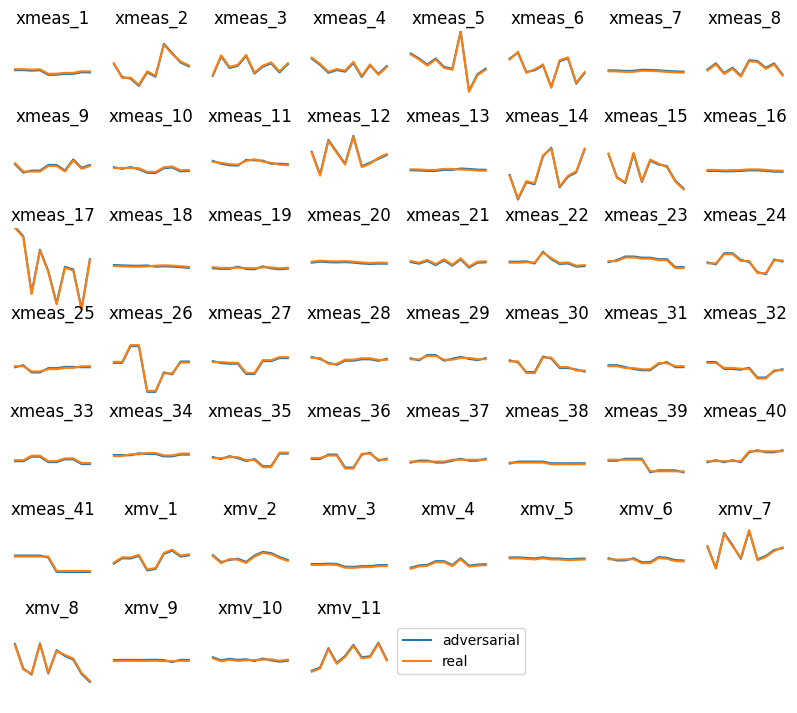

In [9]:
plt.figure(figsize=(10, 10))
for i in range(52):
    plt.subplot(8, 8, i+1)
    plt.title(dataset.df.columns[i])
    plt.plot(adv_sample.numpy()[0, :, i], label='adversarial')
    plt.plot(sample[0, :, i], label='real')
    plt.axis('off')
    plt.ylim(sample[0].min(), sample[0].max())
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [10]:
pred = fddmodel.predict(adv_sample)
pred = pd.Series(pred, index=index, name='pred')

evaluator = FDDEvaluator(step_size=1)
evaluator.print_metrics(label, pred)

FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.4746/0.0014
    Fault 02: 0.8763/0.0065
    Fault 03: 0.0000/0.3858
    Fault 04: 0.0113/0.0000
    Fault 05: 0.2063/0.0047
    Fault 06: 0.8431/0.0000
    Fault 07: 0.9957/0.0000
    Fault 08: 0.1529/0.0947
    Fault 09: 0.0000/0.0000
    Fault 10: 0.0000/0.0015
    Fault 11: 0.0000/0.0000
    Fault 12: 0.0330/0.2822
    Fault 13: 0.0636/0.1060
    Fault 14: 0.0000/0.0000
    Fault 15: 0.0000/0.0000
    Fault 16: 0.0000/0.0013
    Fault 17: 0.7945/0.0483
    Fault 18: 0.7707/0.0063
    Fault 19: 0.0000/0.0511
    Fault 20: 0.4088/0.0059
Detection TPR: 0.5165
Detection FPR: 0.9957
Average Detection Delay (ADD): 33.55
Total Correct Diagnosis Rate (Total CDR): 0.5450

Clustering metrics
-----------------
Adjusted Rand Index (ARI): 0.1482
Normalized Mutual Information (NMI): 0.4815
Unsupervised Clustering Accuracy (ACC): 0.3657


99% FP - модельн не рабоатет
